<div align="center">

<img src="https://iaaa.ai/wp-content/uploads/2023/11/Final-IAAA.png" width="600" height="600">
</div>

<h1 align="center"> Autoencoders </h1>
<h5 align="center">Designer & Developer: Mobin Nesari</h5>

# Autoencoder

## Introduction

An autoencoder, also known as autoassociator or Diabolo networks, is an artificial neural network employed to recreate the given input. It takes a set of <b>unlabeled</b> inputs, encodes them and then tries to extract the most valuable information from them. They are used for feature extraction, learning generative models of data, dimensionality reduction and can be used for compression. 

Autoencoders are based on Restricted Boltzmann Machines, are employed in some of the largest deep learning applications. They are the building blocks of Deep Belief Networks (DBN).

<div style="text-align: center;">
    <img src="https://ibm.box.com/shared/static/xlkv9v7xzxhjww681dq3h1pydxcm4ktp.png" width=400 >
</div>

## Autoencoder Structure 

<div style="text-align: center;">
    <img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1560249044/deep_autoencoder.png">
</div>

An autoencoder can be divided in two parts, the <b>encoder</b> and the <b>decoder</b>.

The encoder needs to compress the representation of an input. In this case we are going to reduce the dimension. The decoder works like encoder network in reverse. It works to recreate the input, as closely as possible. This plays an important role during training, because it forces the autoencoder to select the most important features in the compressed representation.

<h2>Training: Loss function</h2>

An autoencoder uses the Loss function to properly train the network. The Loss function will calculate the differences between our output and the expected results. After that, we can minimize this error with gradient descent. There are more than one type of Loss function, it depends on the type of data.

**Binary Values:**
$$l(f(x)) = - \sum_{k} (x_k log(\hat{x}_k) + (1 - x_k) \log (1 - \hat{x}_k) \ )$$

For binary values, we can use an equation based on the sum of Bernoulli's cross-entropy.  $x_k$ is one of our inputs and $\hat{x}_k$ is the respective output. We use this function so that if $x_k$ equals to one, we want to push $\hat{x}_k$ as close as possible to one. The same if $x_k$ equals to zero. If the value is one, we just need to calculate the first part of the formula, that is, $- x_k log(\hat{x}_k)$. Which, turns out to just calculate $- log(\hat{x}_k)$. And if the value is zero, we need to calculate just the second part, $(1 - x_k) \log (1 - \hat{x}_k) \ )$ - which turns out to be $log (1 - \hat{x}_k) $.

**Real values:**
$$l(f(x)) = - \frac{1}{2}\sum_{k} (\hat{x}_k- x_k \ )^2$$

As the above function would behave badly with inputs that are not 0 or 1, we can use the sum of squared differences for our Loss function.

As it was with the above example, $x_k$ is one of our inputs and $\hat{x}_k$ is the respective output, and we want to make our output as similar as possible to our input.

## MNIST

Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

Now, let's give the parameters that are going to be used by our NN.

In [3]:
# MNIST Dataset parameters.
num_features = 784  # data features (img shape: 28*28).

# Training parameters.
batch_size = 128
epochs = 50

# Network Parameters
hidden_1 = 128  # 1st layer num features.
hidden_2 = 64   # 2nd layer num features (the latent dim).


In [4]:
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor

def load_data(choice='mnist', labels=False):
    if choice not in ['mnist', 'fashion_mnist']:
        raise ValueError('Choices are mnist and fashion_mnist')
    
    if choice == 'mnist':
        dataset_class = MNIST
    else:
        dataset_class = FashionMNIST
    
    train_data = dataset_class(root='./data', train=True, download=True, transform=ToTensor())
    test_data = dataset_class(root='./data', train=False, download=True, transform=ToTensor())
    
    X_train, y_train = train_data.data / 255., train_data.targets
    X_test, y_test = test_data.data / 255., test_data.targets
    
    X_train = X_train.reshape([-1, 784]).float()
    X_test = X_test.reshape([-1, 784]).float()
    
    if labels:
        return (X_train, y_train), (X_test, y_test)
    return X_train, X_test


def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (28, 28)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (28, 28)), aspect='auto')
    plt.tight_layout()


In [5]:
def plot_digits(X, y, encoder, batch_size=128):
    """Plots labels and MNIST digits as function of 2D latent vector

    Parameters:
    ----------
    encoder: nn.Module
        A PyTorch model instance
    X: torch.Tensor
        Test data
    y: torch.Tensor
        Test data labels
    batch_size: int
        Prediction batch size
    """
    # display a 2D plot of the digit classes in the latent space
    with torch.no_grad():
        encoder.eval()
        z_mean, _, _ = encoder(X)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y)
    plt.colorbar()
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.show()
    
    
def generate_manifold(decoder):
    """Generates a manifold of MNIST digits from a random noisy data.

    Parameters:
    ----------
    decoder: nn.Module
        A PyTorch model instance
    """
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    
    decoder.eval()
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]]).float()
                x_decoded = decoder(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size).cpu().numpy()
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0] Latent Dimension")
    plt.ylabel("z[1] Latent Dimension")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()


Now we need to create our encoder/decoder. For this, we are going to use sigmoidal functions. Sigmoidal functions delivers great results with this type of network. This is due to having a good derivative that is well-suited to backpropagation.

### Encoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.encoder(x)


# Define the encoder model
encoder_model = Encoder(num_features, hidden_1, hidden_2)
print(encoder_model)


Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
)


### Decoder

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size_1, output_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)


# Define the decoder model
decoder_model = Decoder(hidden_2, hidden_1, num_features)
print(decoder_model)


Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


### Autoencoder Model

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Define the autoencoder model
autoencoder_model = Autoencoder(encoder_model, decoder_model)
print(autoencoder_model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters())

# Move model to appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder_model.to(device)

# Summary of the autoencoder model
print(autoencoder_model)


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): Sigmoid()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)
Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): Sigmoid()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)


In [12]:
# Load MNIST data
X_train, X_test = load_data('mnist')

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

# Move data to appropriate device (e.g., GPU if available)
X_train = X_train.to(device)
X_test = X_test.to(device)

# Training loop
for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]

        # Forward pass
        outputs = autoencoder_model(batch_X)

        # Compute loss
        loss = criterion(outputs, batch_X)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


/tmp/ipykernel_33/2948277575.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
/tmp/ipykernel_33/2948277575.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)


Epoch [1/50], Loss: 0.0617
Epoch [2/50], Loss: 0.0598
Epoch [3/50], Loss: 0.0524
Epoch [4/50], Loss: 0.0429
Epoch [5/50], Loss: 0.0391
Epoch [6/50], Loss: 0.0357
Epoch [7/50], Loss: 0.0329
Epoch [8/50], Loss: 0.0303
Epoch [9/50], Loss: 0.0283
Epoch [10/50], Loss: 0.0263
Epoch [11/50], Loss: 0.0245
Epoch [12/50], Loss: 0.0227
Epoch [13/50], Loss: 0.0214
Epoch [14/50], Loss: 0.0203
Epoch [15/50], Loss: 0.0192
Epoch [16/50], Loss: 0.0182
Epoch [17/50], Loss: 0.0173
Epoch [18/50], Loss: 0.0165
Epoch [19/50], Loss: 0.0159
Epoch [20/50], Loss: 0.0153
Epoch [21/50], Loss: 0.0148
Epoch [22/50], Loss: 0.0143
Epoch [23/50], Loss: 0.0138
Epoch [24/50], Loss: 0.0133
Epoch [25/50], Loss: 0.0129
Epoch [26/50], Loss: 0.0126
Epoch [27/50], Loss: 0.0123
Epoch [28/50], Loss: 0.0120
Epoch [29/50], Loss: 0.0118
Epoch [30/50], Loss: 0.0115
Epoch [31/50], Loss: 0.0113
Epoch [32/50], Loss: 0.0111
Epoch [33/50], Loss: 0.0109
Epoch [34/50], Loss: 0.0107
Epoch [35/50], Loss: 0.0105
Epoch [36/50], Loss: 0.0103
E

Let's simply visualize our graphs!

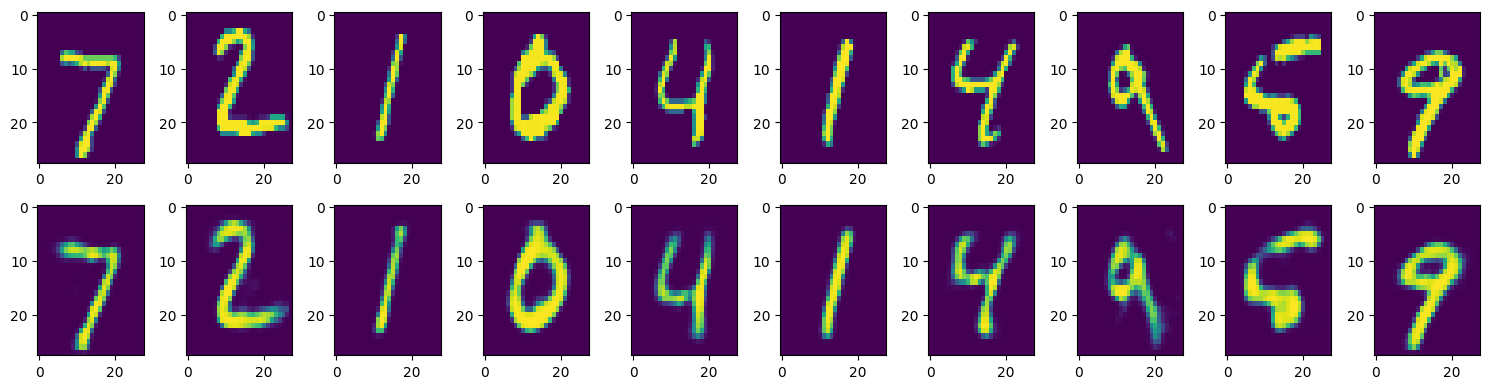

In [13]:
# Set the model to evaluation mode
autoencoder_model.eval()

# Get predictions for the first 10 samples from the test set
with torch.no_grad():
    y_true = X_test[:10]
    y_pred = autoencoder_model(y_true)

# Convert predictions to numpy arrays
y_true = y_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()

# Plot the predictions
plot_predictions(y_true, y_pred)


## Fashion MNIST

Let's try our network with fashion mnist to see how well it performs.

In [14]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.encoder(x)


# Define the encoder model
encoder_model = Encoder(num_features, hidden_1, hidden_2)
print(encoder_model)

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size_1, output_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)


# Define the decoder model
decoder_model = Decoder(hidden_2, hidden_1, num_features)
print(decoder_model)

# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Define the autoencoder model
autoencoder_model = Autoencoder(encoder_model, decoder_model)
print(autoencoder_model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters())

# Move model to appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder_model.to(device)

# Summary of the autoencoder model
print(autoencoder_model)


Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Sigmoid()
  )
)
Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): Sigmoid()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)
Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
 

In [15]:
# Load Fashion MNIST data
X_train, X_test = load_data('fashion_mnist')

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

# Move data to appropriate device (e.g., GPU if available)
X_train = X_train.to(device)
X_test = X_test.to(device)

# Training loop
for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]

        # Forward pass
        outputs = autoencoder_model(batch_X)

        # Compute loss
        loss = criterion(outputs, batch_X)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


100%|██████████| 26421880/26421880 [00:02<00:00, 12260152.80it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209869.14it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 1001623.81it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16125673.63it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/tmp/ipykernel_33/3336662049.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
/tmp/ipykernel_33/3336662049.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)


Epoch [1/50], Loss: 0.0426
Epoch [2/50], Loss: 0.0341
Epoch [3/50], Loss: 0.0270
Epoch [4/50], Loss: 0.0234
Epoch [5/50], Loss: 0.0215
Epoch [6/50], Loss: 0.0203
Epoch [7/50], Loss: 0.0192
Epoch [8/50], Loss: 0.0183
Epoch [9/50], Loss: 0.0177
Epoch [10/50], Loss: 0.0171
Epoch [11/50], Loss: 0.0165
Epoch [12/50], Loss: 0.0160
Epoch [13/50], Loss: 0.0154
Epoch [14/50], Loss: 0.0150
Epoch [15/50], Loss: 0.0146
Epoch [16/50], Loss: 0.0142
Epoch [17/50], Loss: 0.0139
Epoch [18/50], Loss: 0.0136
Epoch [19/50], Loss: 0.0133
Epoch [20/50], Loss: 0.0130
Epoch [21/50], Loss: 0.0127
Epoch [22/50], Loss: 0.0125
Epoch [23/50], Loss: 0.0123
Epoch [24/50], Loss: 0.0121
Epoch [25/50], Loss: 0.0119
Epoch [26/50], Loss: 0.0117
Epoch [27/50], Loss: 0.0115
Epoch [28/50], Loss: 0.0113
Epoch [29/50], Loss: 0.0112
Epoch [30/50], Loss: 0.0110
Epoch [31/50], Loss: 0.0109
Epoch [32/50], Loss: 0.0108
Epoch [33/50], Loss: 0.0107
Epoch [34/50], Loss: 0.0106
Epoch [35/50], Loss: 0.0105
Epoch [36/50], Loss: 0.0104
E

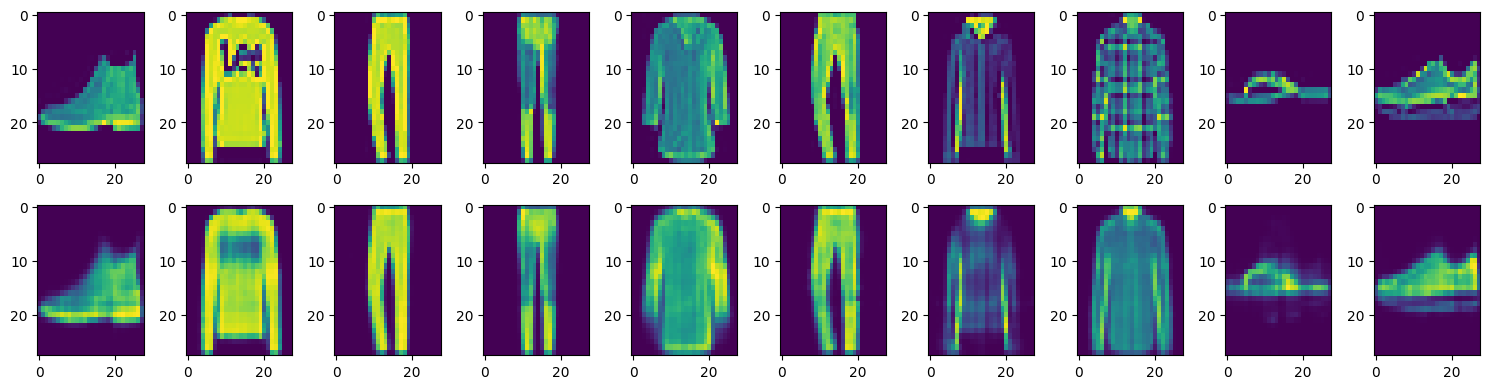

In [16]:
# Set the model to evaluation mode
autoencoder_model.eval()

# Get predictions for the first 10 samples from the test set
with torch.no_grad():
    y_true = X_test[:10]
    y_pred = autoencoder_model(y_true)

# Convert predictions to numpy arrays
y_true = y_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()

# Plot the predictions
plot_predictions(y_true, y_pred)

As can be seen construction was okay not perfect due to some noise in the images. Increasing layer sizes may help.